
# Sports filed registration

In [1]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda

--2021-12-27 09:08:52--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.20.126
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-12-27 09:08:52--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?nUcuWGdX962C7Yce5v8I8Xzr_noKKm2TYhTtLY0x7WyklWZ7TCPdIUAetrScpS-93Ko6oisuJ31Q65tGOLMCQankp1GSyw6whU3wxiLnOPOuo

In [2]:
!git clone https://github.com/vcg-uvic/sportsfield_release

Cloning into 'sportsfield_release'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 98 (delta 21), reused 88 (delta 13), pack-reused 0
Unpacking objects: 100% (98/98), done.


In [3]:
%cd sportsfield_release/

/content/sportsfield_release


In [4]:
import os

import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from utils import utils, warp, image_utils, constant_var
from models import end_2_end_optimization
from options import fake_options
import cv2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# if want to run on CPU, please make it False
constant_var.USE_CUDA = True
utils.fix_randomness()

# if GPU is RTX 20XX, please disable cudnn
torch.backends.cudnn.enabled = True

In [27]:
# set some options
opt = fake_options.FakeOptions()
opt.batch_size = 1
opt.coord_conv_template = True
opt.error_model = 'loss_surface'
opt.error_target = 'iou_whole'
opt.goal_image_path = '/content/drive/MyDrive/testing/ssssss.jfif'
opt.guess_model = 'init_guess'
opt.homo_param_method = 'deep_homography'
opt.load_weights_error_model = '/content/drive/MyDrive/out/pretrained_loss_surface'
opt.load_weights_upstream = '/content/drive/MyDrive/out/pretrained_init_guess'
opt.lr_optim = 1e-5
opt.need_single_image_normalization = True
opt.need_spectral_norm_error_model = True
opt.need_spectral_norm_upstream = False
opt.optim_criterion = 'l1loss'
opt.optim_iters = 200
opt.optim_method = 'stn'
opt.optim_type = 'adam'
opt.out_dir = './out'
opt.prevent_neg = 'sigmoid'
opt.template_path = './data/world_cup_template.png'
opt.warp_dim = 8
opt.warp_type = 'homography'

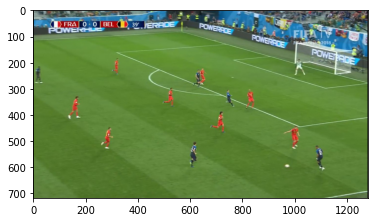

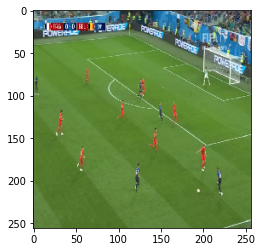

mean of goal image: 3.1044087300813317e-09
std of goal image: 0.9999949336051941


In [28]:
# read original image
goal_image = imageio.imread(opt.goal_image_path, pilmode='RGB')
plt.imshow(goal_image)
plt.show()
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))
pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
plt.imshow(goal_image)
plt.show()
# covert np image to torch image, and do normalization
goal_image = utils.np_img_to_torch_img(goal_image)
if opt.need_single_image_normalization:
    goal_image = image_utils.normalize_single_image(goal_image)
print('mean of goal image: {0}'.format(goal_image.mean()))
print('std of goal image: {0}'.format(goal_image.std()))

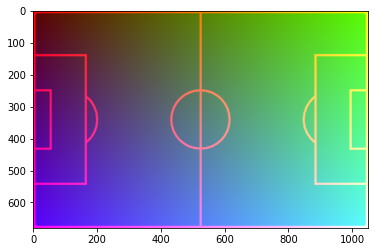

mean of template: -1.7142274089110288e-07
std of template: 0.9999995231628418


In [29]:
# read template image
template_image = imageio.imread(opt.template_path, pilmode='RGB')
template_image = template_image / 255.0
if opt.coord_conv_template:
    template_image = image_utils.rgb_template_to_coord_conv_template(template_image)
plt.imshow(template_image)
plt.show()
# covert np image to torch image, and do normalization
template_image = utils.np_img_to_torch_img(template_image)
if opt.need_single_image_normalization:
    template_image = image_utils.normalize_single_image(template_image)
print('mean of template: {0}'.format(template_image.mean()))
print('std of template: {0}'.format(template_image.std()))

In [30]:
e2e = end_2_end_optimization.End2EndOptimFactory.get_end_2_end_optimization_model(opt)

---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: /content/drive/MyDrive/out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/drive/MyDrive/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


In [31]:
orig_homography, optim_homography = e2e.optim(goal_image[None], template_image)

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/drive/MyDrive/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


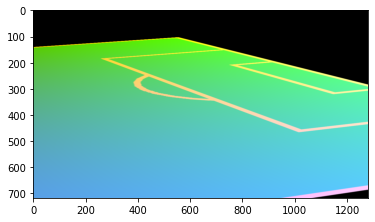

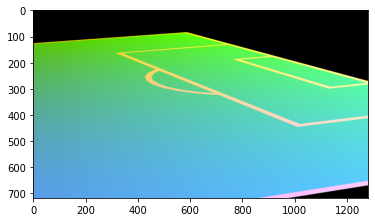

In [32]:
# reload image and template for visualization
# overload goal image
goal_image_draw = imageio.imread(opt.goal_image_path, pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0
outshape = goal_image_draw.shape[0:2]

# overload template image
template_image_draw = imageio.imread(opt.template_path, pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)

# warp template image with initial guess
warped_tmp_orig = warp.warp_image(template_image_draw, orig_homography, out_shape=outshape)[0]
warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
plt.imshow(warped_tmp_orig)
plt.show()

# warp template image with optimized guess
warped_tmp_optim = warp.warp_image(template_image_draw, optim_homography, out_shape=outshape)[0]
warped_tmp_optim = utils.torch_img_to_np_img(warped_tmp_optim)
plt.imshow(warped_tmp_optim)
plt.show()

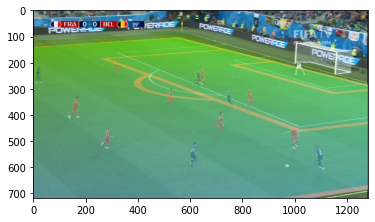

In [33]:
# show initial guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_orig[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_orig[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()

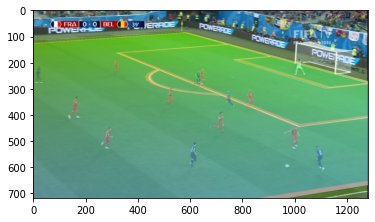

In [34]:
# show optimized guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_optim[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_optim[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


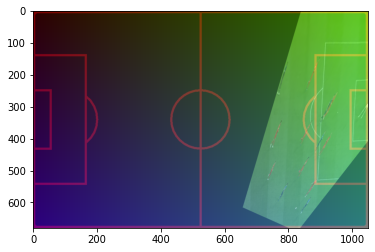

In [35]:
# show original top-down view
H_inv = torch.inverse(orig_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp.warp_image(utils.np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


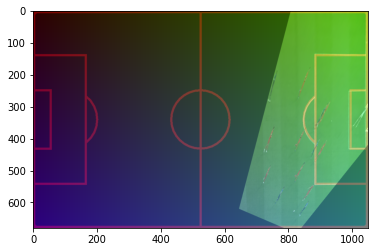

In [36]:
# show optimized top-down view
H_inv = torch.inverse(optim_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp.warp_image(utils.np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.show()

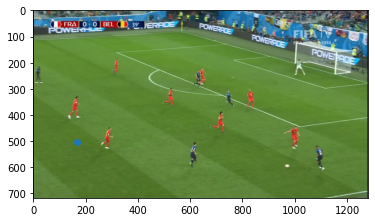

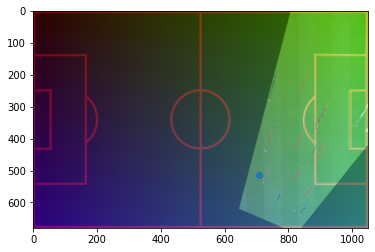

In [37]:
# warp a point from frame to template
frame_point = np.array([167, 503])
plt.imshow( imageio.imread(opt.goal_image_path, pilmode='RGB'))
plt.scatter(frame_point[0], frame_point[1])
plt.show()

x = torch.tensor(frame_point[0] / 1280 - 0.5).float()
y = torch.tensor(frame_point[1] / 720 - 0.5).float()
xy = torch.stack([x, y, torch.ones_like(x)])
xy_warped = torch.matmul(optim_homography.cpu(), xy)  # H.bmm(xy)
xy_warped, z_warped = xy_warped.split(2, dim=1)

# we multiply by 2, since our homographies map to
# coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
x_warped, y_warped = torch.unbind(xy_warped, dim=1)
# [-1, 1] -> [0, 1]
x_warped = (x_warped.item() * 0.5 + 0.5) * 1050
y_warped = (y_warped.item() * 0.5 + 0.5) * 680

plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.scatter(x_warped, y_warped)
plt.show()

The optimized result is more aligned with the input frame than initial guess. Our methods trained on only 170 images from World Cup 2014, and can successfully generalize to games from different time, stadium, and camera pose.

### Apply to video

In [39]:
opt.optim_iters = 80

In [40]:
video_cap = cv2.VideoCapture('/content/drive/MyDrive/testing/WhatsApp Video 2021-12-14 at 11.22.48 PM.mp4')
frame_list = []
while True:
    success, image = video_cap.read()
    if not success:
        break
    pil_image = Image.fromarray(np.uint8(image[..., ::-1]))
    pil_image = pil_image.resize([1280, 720], resample=Image.NEAREST)
    image = np.array(pil_image)
    frame_list.append(image)

In [41]:
orig_homography_list = []
for idx, frame in enumerate(frame_list):
    pil_image = Image.fromarray(np.uint8(frame))
    pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
    frame = np.array(pil_image)
    frame = utils.np_img_to_torch_img(frame)
    if opt.need_single_image_normalization:
        frame = image_utils.normalize_single_image(frame)
    orig_homography = e2e.homography_inference.infer_upstream_homography(frame[None])
    orig_homography_list.append(orig_homography.detach())

In [42]:
first_frame = True
optim_homography_list = []
for idx, frame in enumerate(frame_list):
    print('{0} / {1}'.format(idx+1, len(frame_list)))
    pil_image = Image.fromarray(np.uint8(frame))
    pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
    frame = np.array(pil_image)
    frame = utils.np_img_to_torch_img(frame)
    if opt.need_single_image_normalization:
        frame = image_utils.normalize_single_image(frame)
    _, optim_homography = e2e.optim(frame[None], template_image, refresh=first_frame)
    optim_homography_list.append(optim_homography.detach())
    first_frame = False

1 / 167
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: /content/drive/MyDrive/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


2 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


3 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


4 / 167


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


5 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


6 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


7 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


8 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


9 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


10 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


11 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


12 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


13 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


14 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


15 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


16 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


17 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


18 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


19 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


20 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


21 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


22 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


23 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


24 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


25 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


26 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


27 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


28 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


29 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


30 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


31 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


32 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


33 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


34 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


35 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


36 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


37 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


38 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


39 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


40 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


41 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


42 / 167


100%|██████████| 80/80 [00:10<00:00,  7.95it/s]


43 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


44 / 167


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


45 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


46 / 167


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


47 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


48 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


49 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


50 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


51 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


52 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


53 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


54 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


55 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


56 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


57 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


58 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


59 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


60 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


61 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


62 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


63 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


64 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


65 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


66 / 167


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


67 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


68 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


69 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


70 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


71 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


72 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


73 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


74 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


75 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


76 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


77 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


78 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


79 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


80 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


81 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


82 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


83 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


84 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


85 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


86 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


87 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


88 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


89 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


90 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


91 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


92 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


93 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


94 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


95 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


96 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


97 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


98 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


99 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


100 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


101 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


102 / 167


100%|██████████| 80/80 [00:10<00:00,  7.93it/s]


103 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


104 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


105 / 167


100%|██████████| 80/80 [00:10<00:00,  7.92it/s]


106 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


107 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


108 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


109 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


110 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


111 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


112 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


113 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


114 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


115 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


116 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


117 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


118 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


119 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


120 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


121 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


122 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


123 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


124 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


125 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


126 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


127 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


128 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


129 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


130 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


131 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


132 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


133 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


134 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


135 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


136 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


137 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


138 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


139 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


140 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


141 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


142 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


143 / 167


100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


144 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


145 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


146 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


147 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


148 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


149 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


150 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


151 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


152 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


153 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


154 / 167


100%|██████████| 80/80 [00:10<00:00,  7.89it/s]


155 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


156 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


157 / 167


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


158 / 167


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


159 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


160 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


161 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


162 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


163 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


164 / 167


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


165 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


166 / 167


100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


167 / 167


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


In [43]:
warped_tmp_orig_list = []
warped_tmp_optim_list = []
for orig_h, optim_h in zip(orig_homography_list, optim_homography_list):
    warped_tmp_orig = warp.warp_image(template_image_draw, orig_h, out_shape=(720, 1280))[0]
    warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
    warped_tmp_orig_list.append(warped_tmp_orig)
    warped_tmp_optim = warp.warp_image(template_image_draw, optim_h, out_shape=(720, 1280))[0]
    warped_tmp_optim = utils.torch_img_to_np_img(warped_tmp_optim)
    warped_tmp_optim_list.append(warped_tmp_optim)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [44]:
def save_to_vid(frame_list, template_list, fname):
    video_name = fname
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1280, 720))
    edge_color = [0, 1.0, 0]
    for frame, template in zip(frame_list, template_list):
        video_content = frame[..., ::-1] / 255.0
        template_content = template
        valid_index = template_content[..., 0]>0
        edge_index = template_content[..., 0] >= 254.0/255.0
        overlay = (video_content[valid_index].astype('float32') + template_content[valid_index].astype('float32'))/2
        out_frame = video_content.copy()
        out_frame[valid_index] = overlay
        out_frame[edge_index] = edge_color
        out_frame = out_frame * 255.0
        out_frame = out_frame.astype('uint8')
        video.write(out_frame)
    cv2.destroyAllWindows()
    video.release()
    os.system("/usr/bin/ffmpeg -y -i {0} -vcodec libx264 {1}".format(fname, fname.replace('.mp4', '_h264.mp4')))

save_to_vid(frame_list, warped_tmp_orig_list, './video_out/orig_overlay.mp4')
save_to_vid(frame_list, warped_tmp_optim_list, './video_out/optim_overlay.mp4')

In [45]:
if not os.path.isfile('./video_out/orig_overlay_h264.mp4') or not os.path.isfile('./video_out/optim_overlay_h264.mp4'):
    assert 0, 'Converting from MJPEG to H264 failed, please manually check the output in ./video_out'

In [46]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="./video_out/orig_overlay_h264.mp4" type="video/mp4">
</video></div>

In [47]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="./video_out/optim_overlay_h264.mp4" type="video/mp4">
</video></div>